# IPL Data Analysis 

_this notebook utilises the following dataset from kaggle: https://www.kaggle.com/datasets/namangarg2075/ipl-match-dataset-2008-2023_

## Understanding the Data

In [50]:
%matplotlib inline

In [51]:
# importing the necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import seaborn as sns 
from collections import Counter
from datascience import sample_proportions
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder


sns.set_style("darkgrid")

In [52]:
# importing the data set 
df = pd.read_csv('Cricket_data.csv')
df.tail(3)

,season,id,name,short_name,description,home_team,away_team,toss_won,decision,1st_inning_score,...,home_playx1,away_playx1,away_key_batsman,away_key_bowler,match_days,umpire1,umpire2,tv_umpire,referee,reserve_umpire
1029,2008.0,336038,Delhi Daredevils v Rajasthan Royals,DC v RR,"1st Semi-Final (N), Indian Premier League at M...",DC,RR,DC,BOWL FIRST,192/9,...,"Gautam Gambhir (BT),Virender Sehwag (BT),Shikh...","Graeme Smith (BT),Swapnil Asnodkar (BT),Sohail...","Shane Watson,Yusuf Pathan","Shane Watson,Munaf Patel",30 May 2008 - night match (20-over match),Billy Bowden,Rudi Koertzen,Billy Doctrove,Javagal Srinath,NaN
1030,2008.0,336039,Chennai Super Kings v Kings XI Punjab,CSK v KXIP,"2nd Semi-Final (N), Indian Premier League at M...",CSK,KXIP,KXIP,BAT FIRST,112/8,...,"Parthiv Patel (WK),Vidyut Sivaramakrishnan (UK...","Shaun Marsh (BT),James Hopes (AR),Kumar Sangak...","Ramesh Powar,Wilkin Mota","Irfan Pathan,Vikram Singh",31 May 2008 - night match (20-over match),Asad Rauf,Daryl Harper,Krishna Hariharan,Srinivas Venkataraghavan,NaN
1031,2008.0,336040,Chennai Super Kings v Rajasthan Royals,CSK v RR,"Final (N), Indian Premier League at Mumbai, Ju...",CSK,RR,RR,BOWL FIRST,163/5,...,"Parthiv Patel (WK),Vidyut Sivaramakrishnan (UK...","Niraj Patel (UKN),Swapnil Asnodkar (BT),Kamran...","Yusuf Pathan,Swapnil Asnodkar","Yusuf Pathan,Shane Watson",1 June 2008 - night match (20-over match),Billy Bowden,Rudi Koertzen,Daryl Harper,Javagal Srinath,MR Singh


In [53]:
df.describe()

,season,id,venue_id,home_overs,home_runs,home_wickets,home_boundaries,away_overs,away_runs,away_wickets,away_boundaries
count,1027.000000,1.032000e+03,1.032000e+03,1019.000000,1019.000000,1019.000000,1019.000000,1017.000000,1017.000000,1017.000000,1017.000000
mean,2015.513145,8.665104e+05,1.255838e+05,19.089892,158.309127,5.791953,19.412169,19.082104,155.962635,5.950836,19.108161
std,4.628349,3.530627e+05,1.644463e+05,2.095061,31.816295,2.404542,5.850536,2.114934,31.334376,2.508164,5.683248
min,2008.000000,3.359820e+05,5.785100e+04,1.100000,2.000000,0.000000,0.000000,3.200000,41.000000,0.000000,3.000000
25%,2012.000000,5.483118e+05,5.799100e+04,19.200000,138.000000,4.000000,15.000000,19.200000,137.000000,4.000000,15.000000
50%,2015.000000,8.298080e+05,5.814200e+04,20.000000,160.000000,6.000000,19.000000,20.000000,158.000000,6.000000,19.000000
75%,2020.000000,1.216501e+06,5.908900e+04,20.000000,180.000000,8.000000,23.000000,20.000000,176.000000,8.000000,23.000000
max,2023.000000,1.370353e+06,1.070094e+06,20.000000,263.000000,10.000000,42.000000,20.000000,257.000000,10.000000,41.000000


In [54]:
# The matches for which the score is not available are of no use, hence dropping them
df = df.dropna(subset=['2nd_inning_score'])

In [55]:
# stroing the original df 
precleaned_df = df.copy()

## Basic Data Cleaning 

In [56]:
# dropping cols which don't seem too valueable 
cols_to_drop = ['reserve_umpire','points','short_name','match_days','name','home_playx1','away_playx1','tv_umpire','highlights']
for col in cols_to_drop:
    df.drop(col, axis=1, inplace=True) if col in df.columns.tolist() else None

In [57]:
# formatting a few columns 
comma_cols = ['home_key_batsman','home_key_bowler','away_key_batsman','away_key_bowler','venue_name']
slash_cols = ['1st_inning_score','2nd_inning_score']


for col in comma_cols:
    df[col] = df[col].apply(lambda x: x.split(',')[0] if pd.notnull(x) else None)
for col in slash_cols:
    df[col] = df[col].apply(lambda x: float(str(x).split('/')[0]) if pd.notnull(x) else None)
df['decision'] = df['decision'].apply(lambda x: x.split()[0].lower() if pd.notnull(x) else None)

## Exploratory Data Analysis

In [58]:
batter_list = df['away_key_batsman'].tolist() + df['home_key_batsman'].tolist()
bowler_list = df['away_key_bowler'].tolist() + df['home_key_bowler'].tolist()
key_batter_count = Counter(batter_list)
key_bowler_count = Counter(bowler_list)

# finding the 5 most impactful bowlers and batters 
high_impact_batters = dict(key_batter_count.most_common(10))
high_impact_bowlers = dict(key_bowler_count.most_common(10))

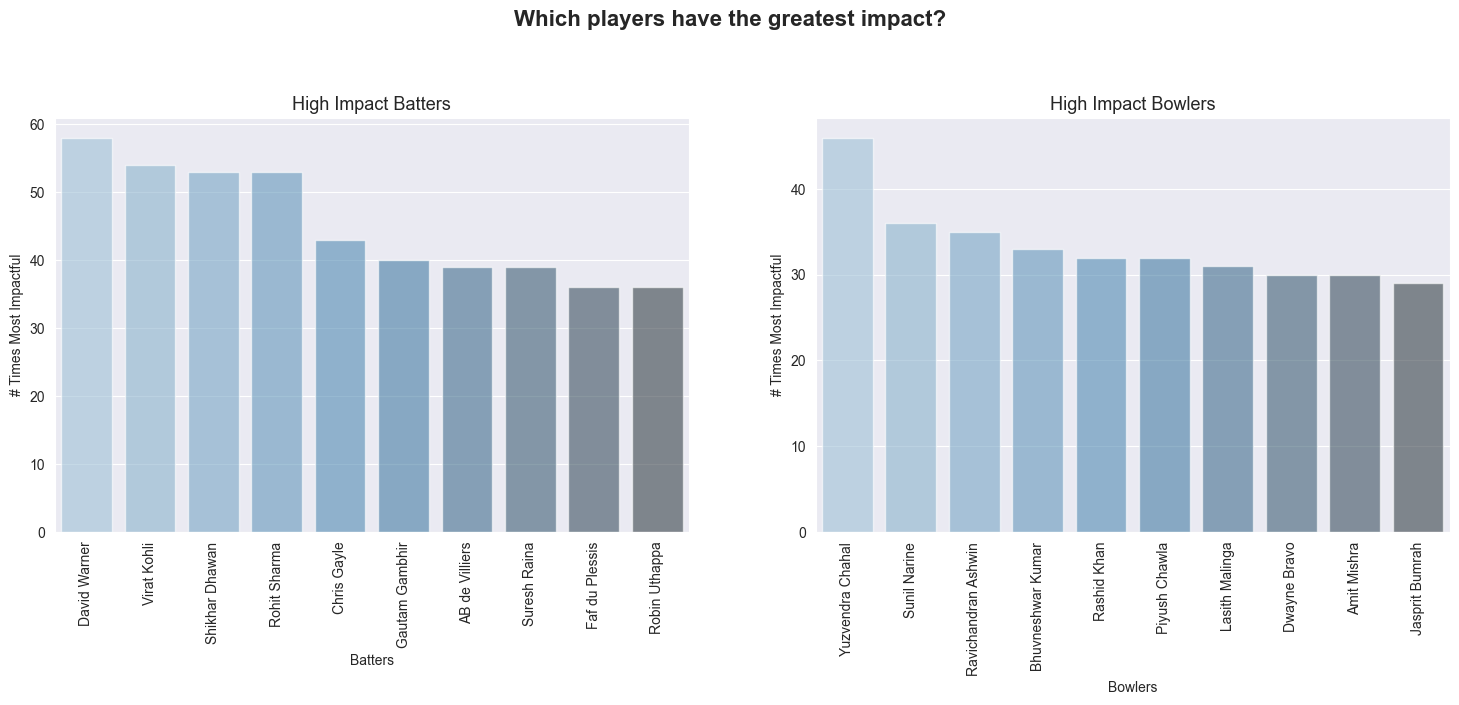

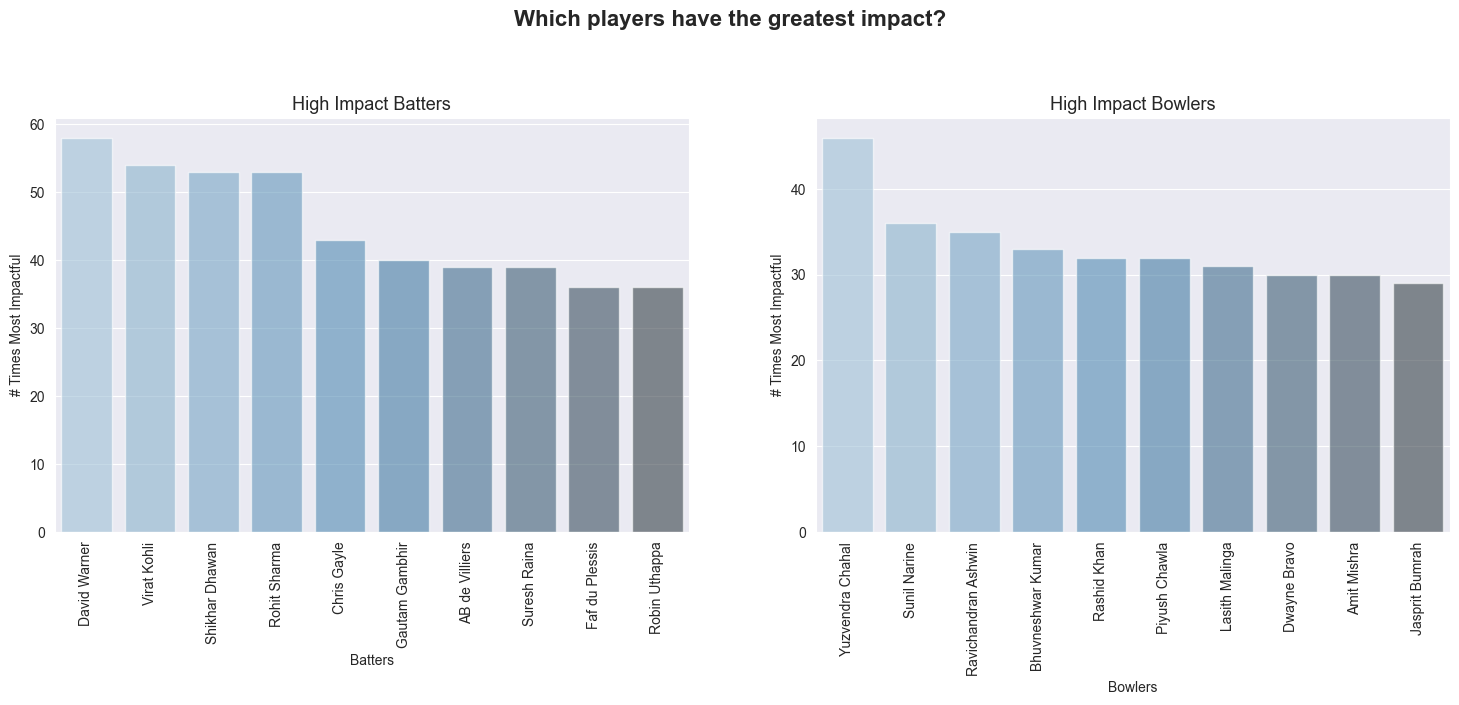

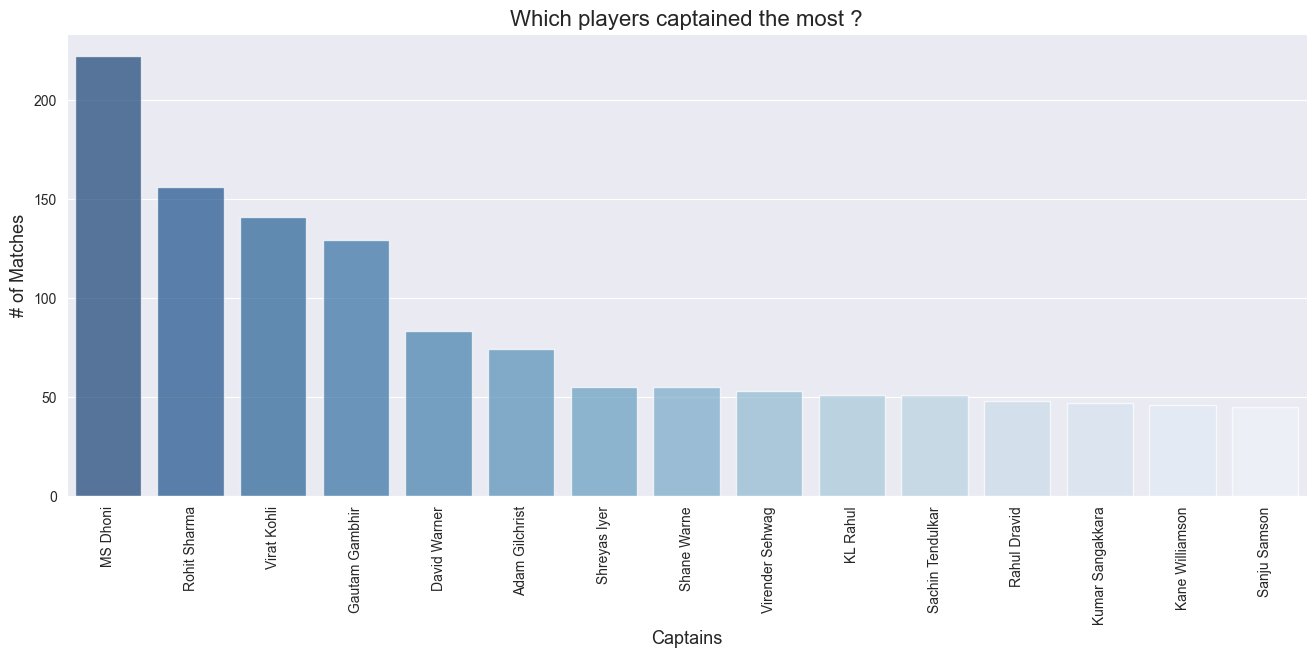

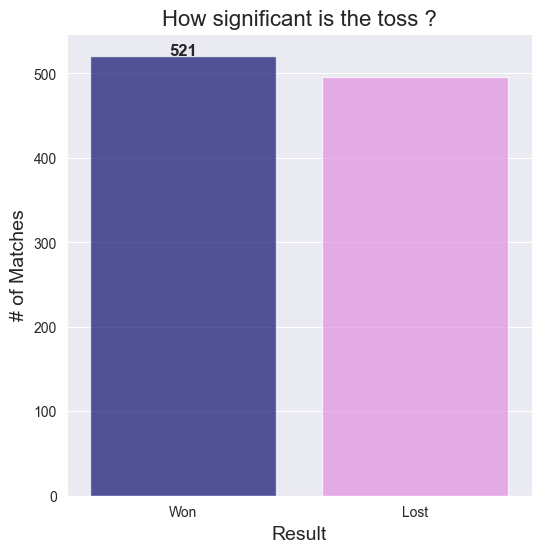

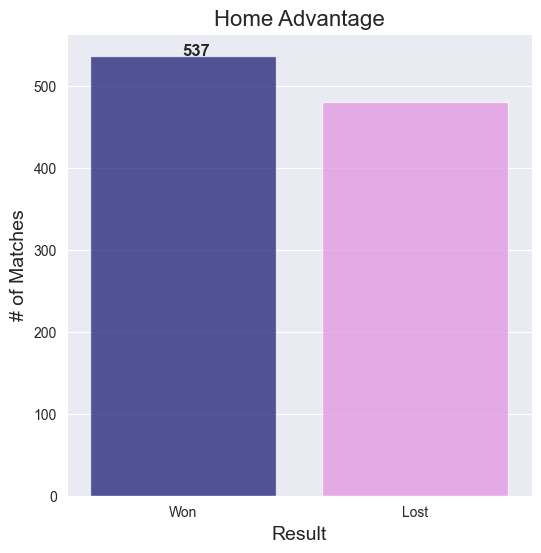

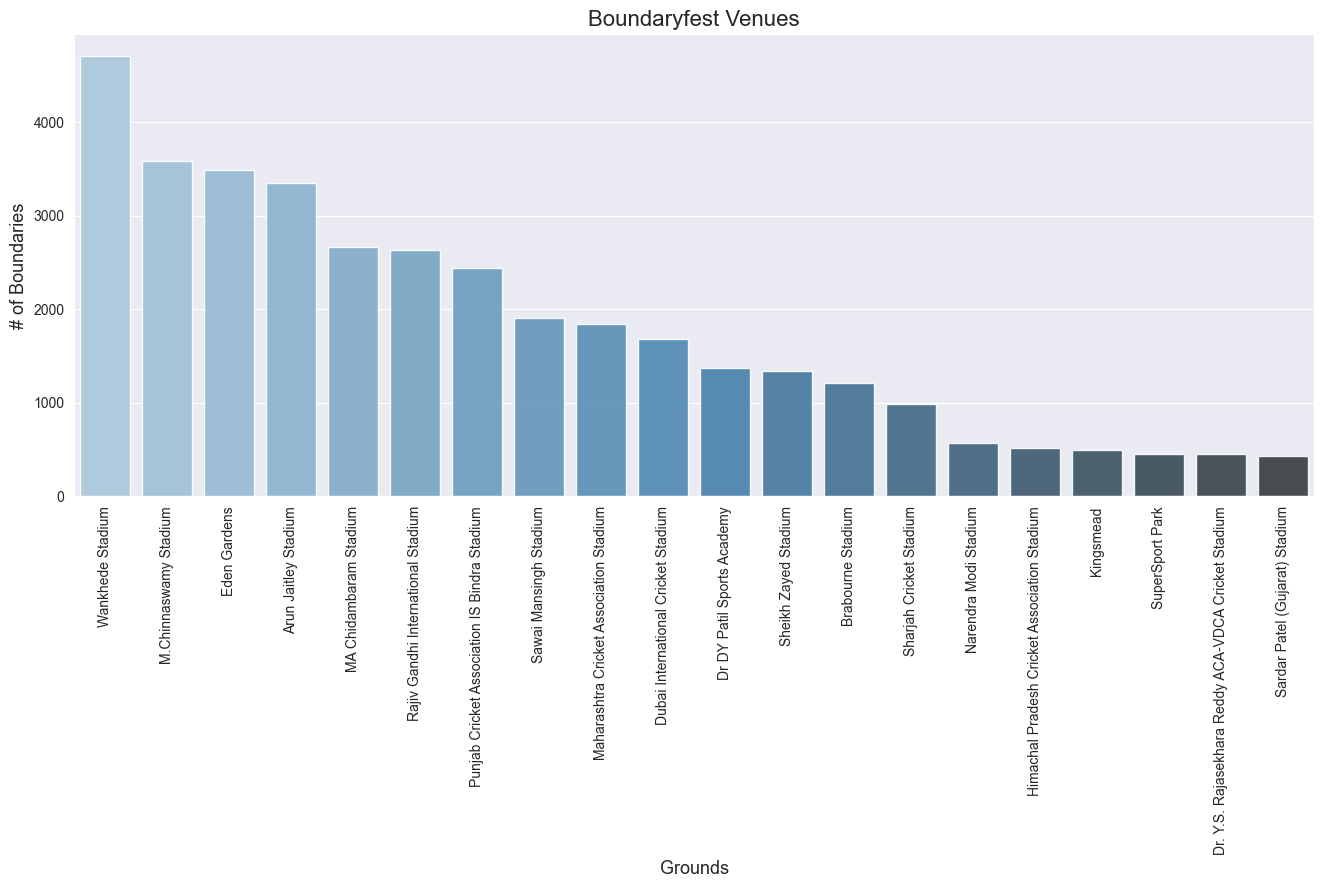

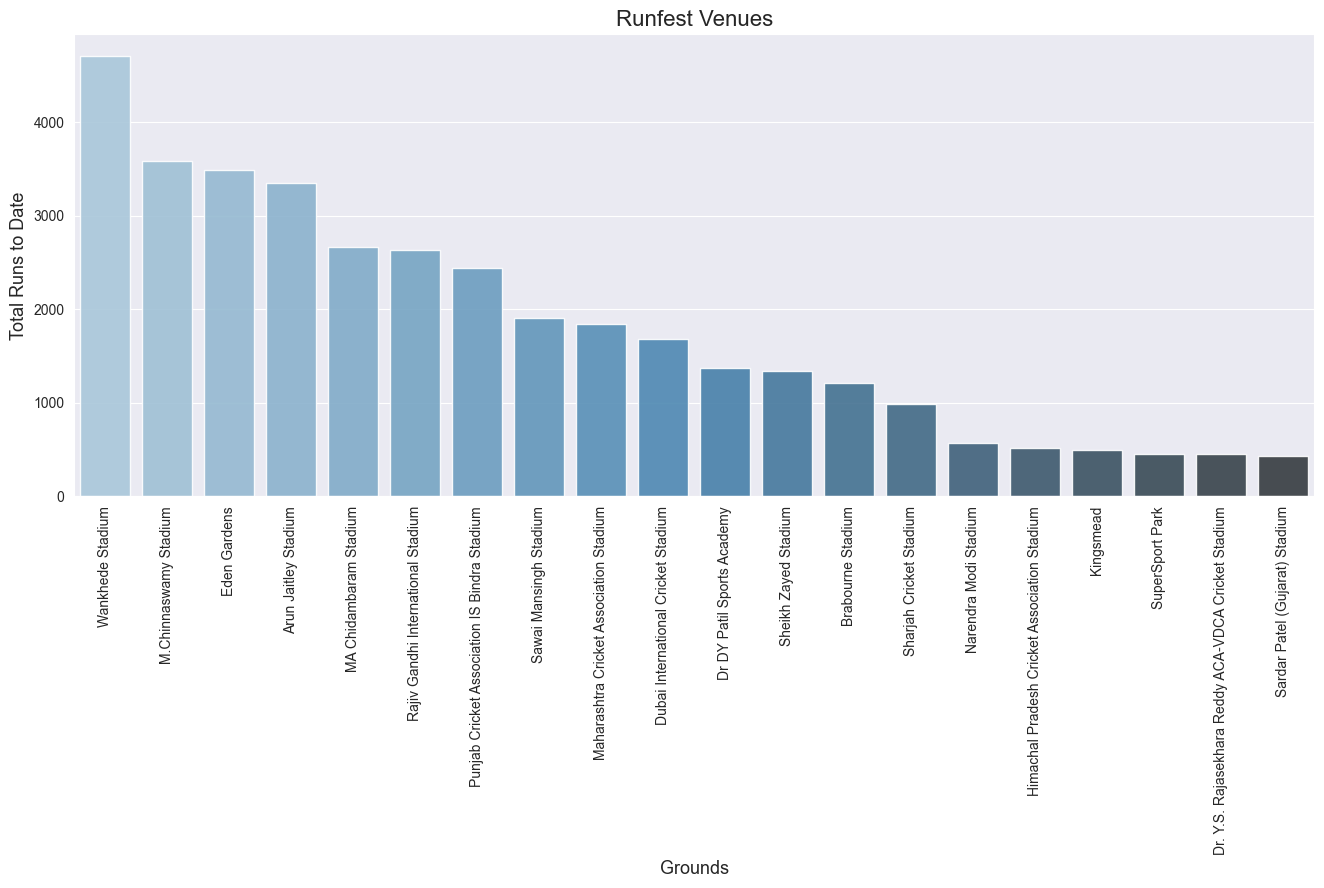

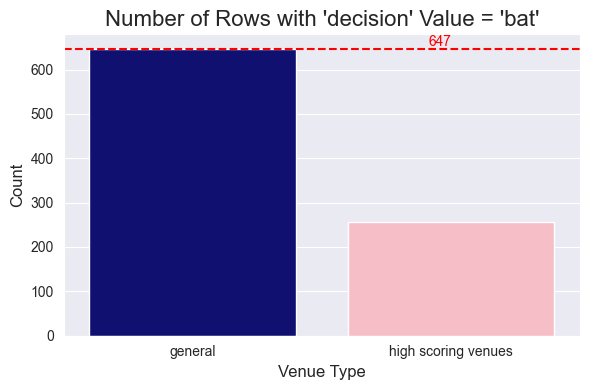

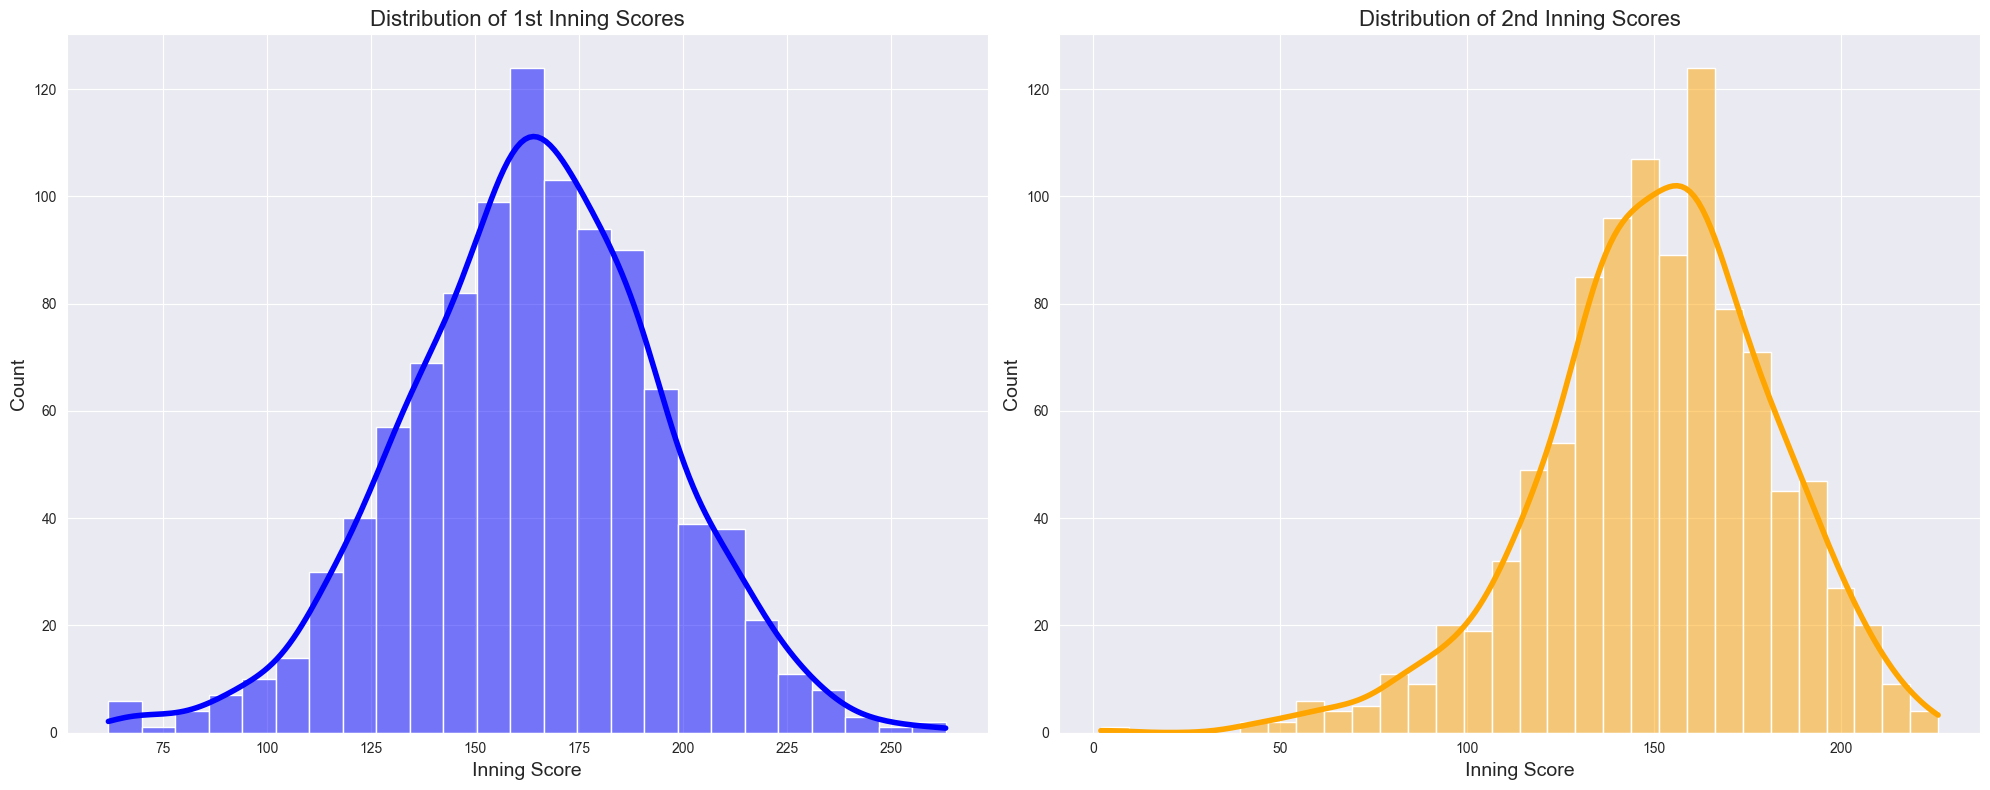

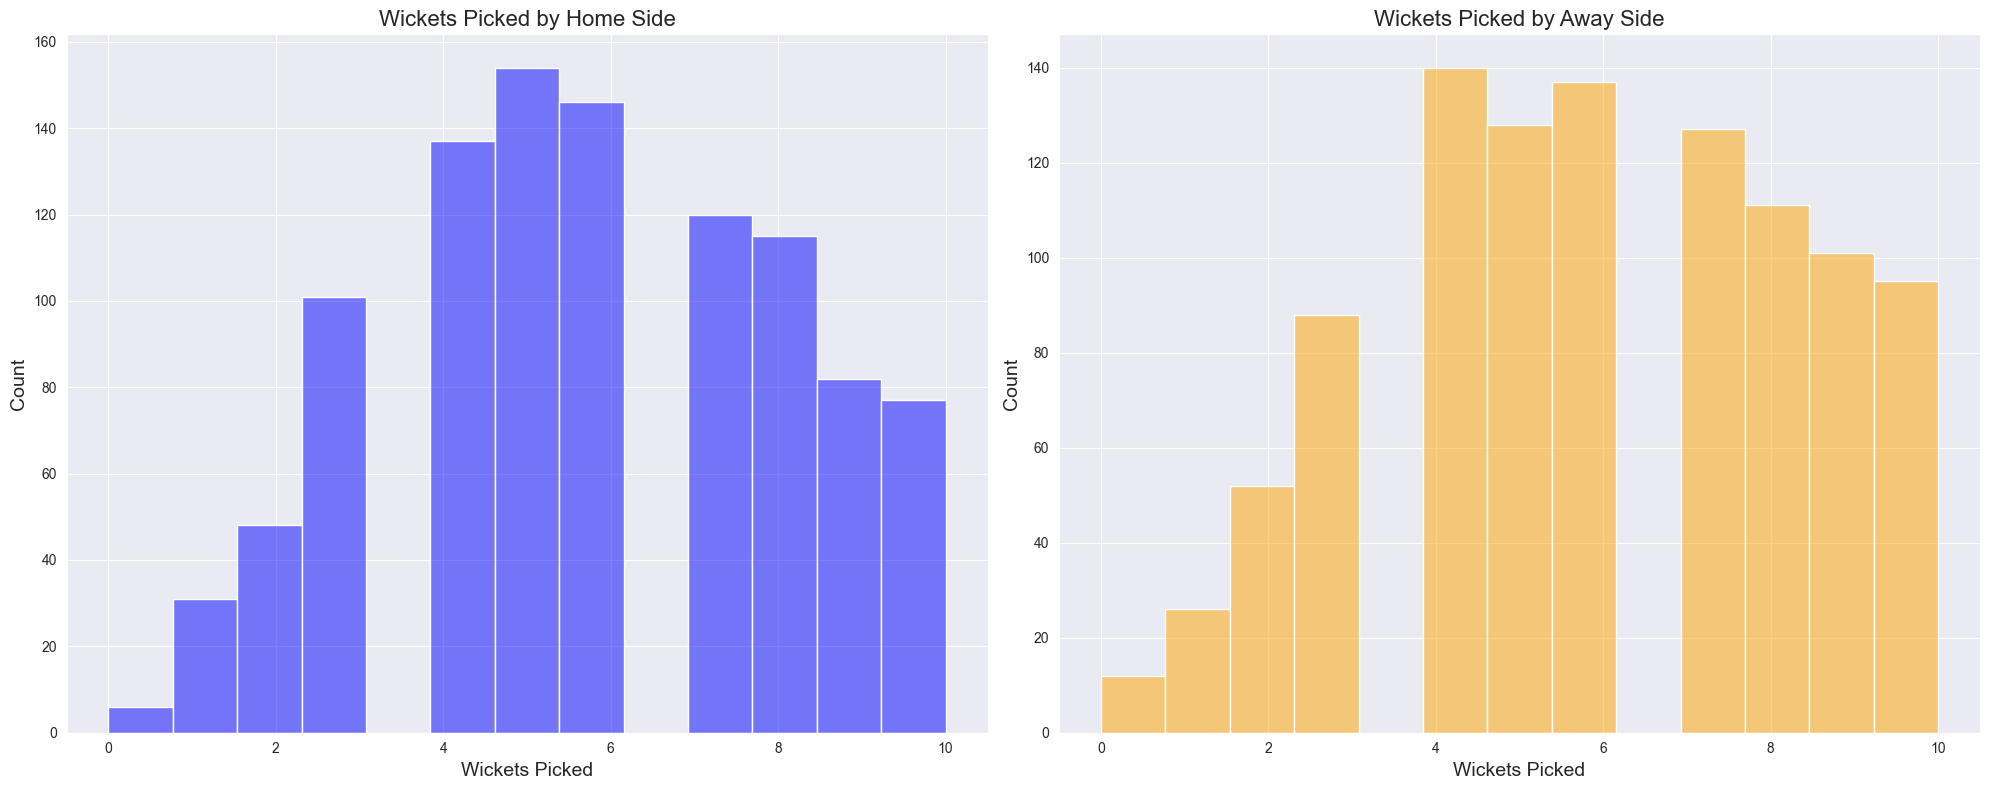

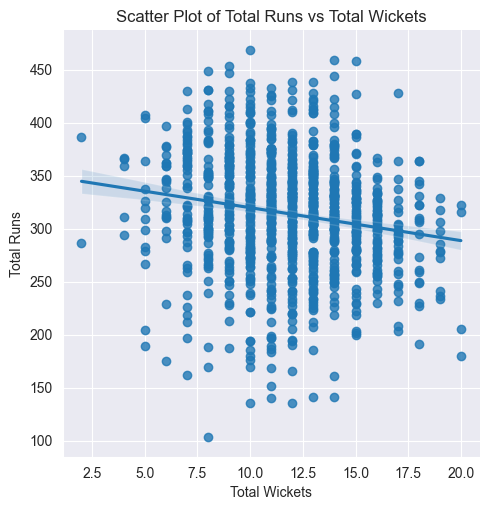

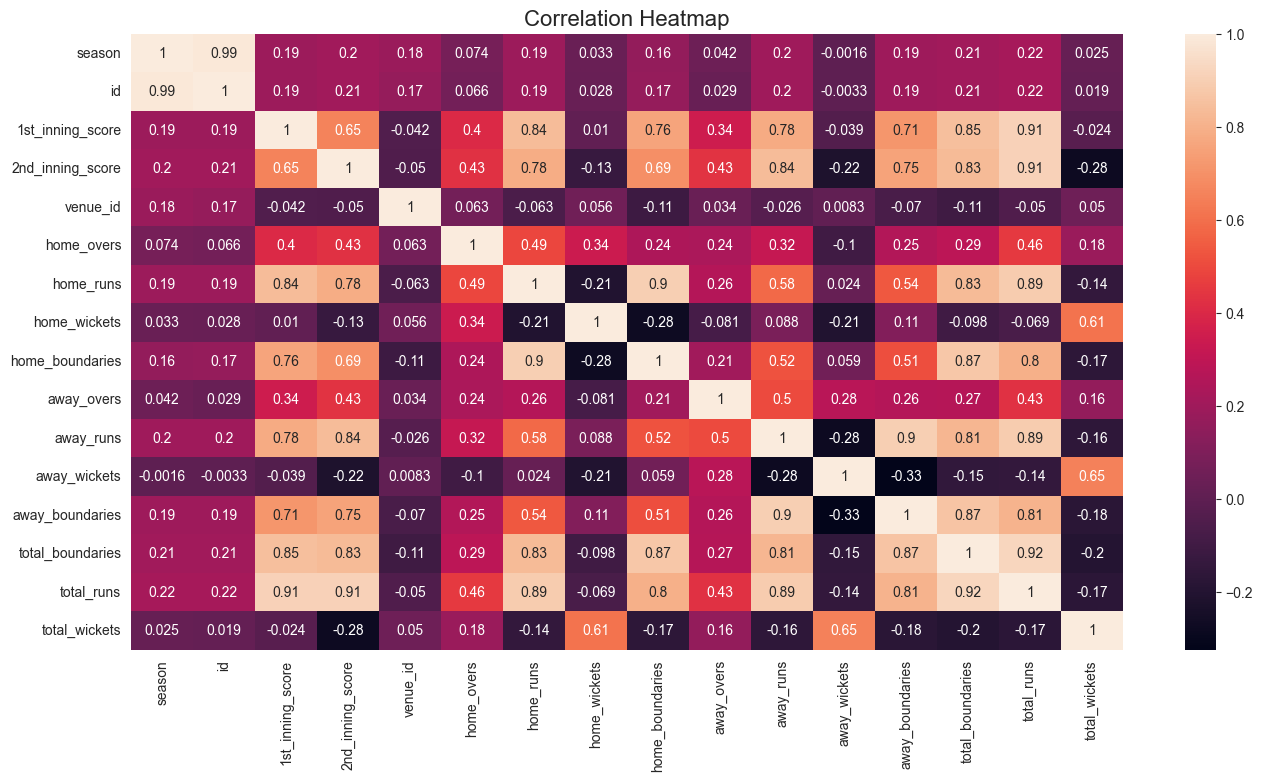

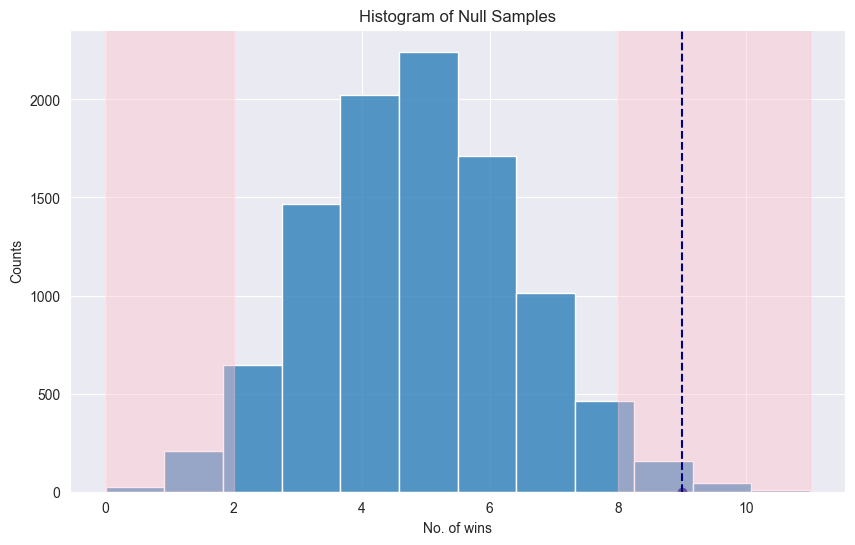

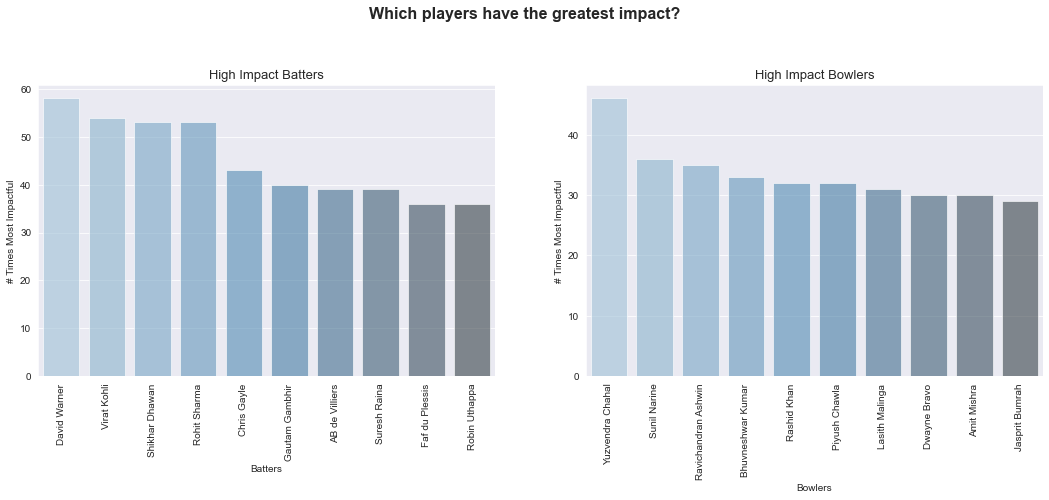

In [59]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

sns.barplot(x=list(high_impact_batters.keys()), y=list(high_impact_batters.values()), ax=ax1, palette="Blues_d",alpha=0.6)
ax1.set_xlabel('Batters')
ax1.set_ylabel('# Times Most Impactful')
ax1.set_title('High Impact Batters',fontsize=13)
ax1.tick_params(axis='x', rotation=90)

sns.barplot(x=list(high_impact_bowlers.keys()), y=list(high_impact_bowlers.values()), ax=ax2, palette="Blues_d",alpha=0.6)
ax2.set_xlabel('Bowlers')
ax2.set_ylabel('# Times Most Impactful')
ax2.set_title('High Impact Bowlers',fontsize=13)
ax2.tick_params(axis='x', rotation=90)

# Adding main title
fig.suptitle('Which players have the greatest impact?', fontsize=16, fontweight='bold')

# Adjust the spacing between subplots and suptitle
plt.subplots_adjust(top=0.8)

# Display the figure
plt.show()

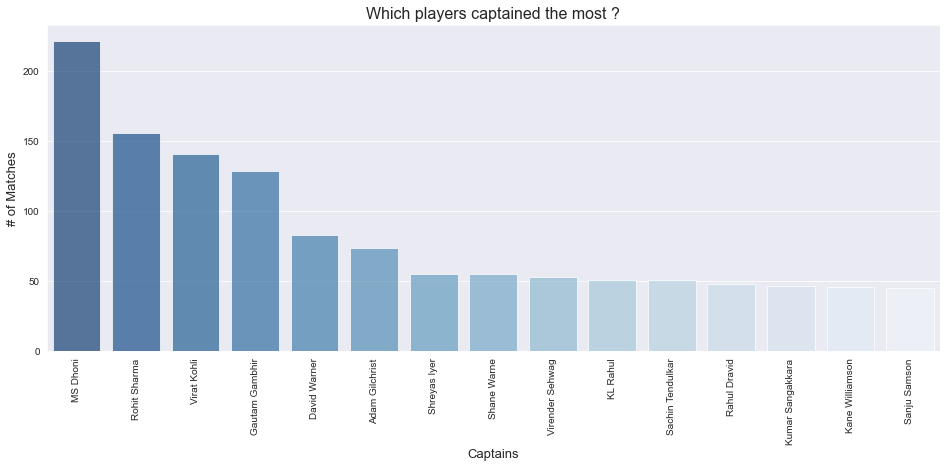

In [60]:
# Trying to gauge the impact of captians 
captains = df['home_captain'].tolist() + df['away_captain'].tolist()
captain_counts = Counter(captains)
succ_captains = dict(captain_counts.most_common(15))

plt.figure(figsize=(16,6))
sns.barplot(x=list(succ_captains.keys()), y=list(succ_captains.values()), palette="Blues_r",alpha=0.7)
plt.title("Which players captained the most ?",fontsize=16)
plt.xlabel("Captains",fontsize=13)
plt.ylabel("# of Matches",fontsize = 13)
plt.xticks(rotation=90)

plt.show()

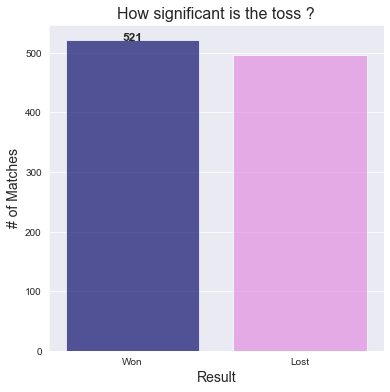

In [61]:
# Examining the significance of the toss 
toss_game_won = (df['winner']==df['toss_won']).sum()

plt.figure(figsize=(6,6))
sns.barplot(x = ['Won','Lost'], y = [toss_game_won,len(df)-toss_game_won],palette = ['navy','violet'],alpha=0.7)
plt.title("How significant is the toss ?",fontsize=16)
plt.ylabel("# of Matches",fontsize=14)
plt.xlabel("Result",fontsize=14)

# Add value label above the "Won" bar
plt.text(0, toss_game_won, str(toss_game_won), ha='center', va='baseline', fontweight='bold',fontsize=12)
# Add dashed horizontal line above the "Won" bar
# plt.axhline(y=toss_game_won, color='black', linestyle='--')

plt.show()

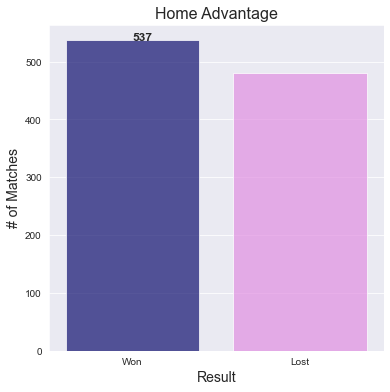

In [62]:
# Examining the advantage of playing at home 
home_wins = (df['home_team'] == df['winner']).sum()

plt.figure(figsize=(6,6))
sns.barplot(x = ['Won','Lost'], y = [home_wins,len(df)-home_wins],palette = ['navy','violet'],alpha=0.7)
plt.title("Home Advantage",fontsize=16)
plt.ylabel("# of Matches",fontsize=14)
plt.xlabel("Result",fontsize=14)

# Add value label above the "Won" bar
plt.text(0, home_wins, str(home_wins), va='baseline', fontweight='bold',fontsize=12)
# Add dashed horizontal line above the "Won" bar
# plt.axhline(y=toss_game_won, color='black', linestyle='--')

plt.show()

In [63]:
df['total_boundaries'] = df['away_boundaries'] + df['home_boundaries']
venue_boundaries = df.groupby('venue_name')['total_boundaries'].sum().sort_values(ascending = False)
venue_boundaries_dict = dict(venue_boundaries[:20])

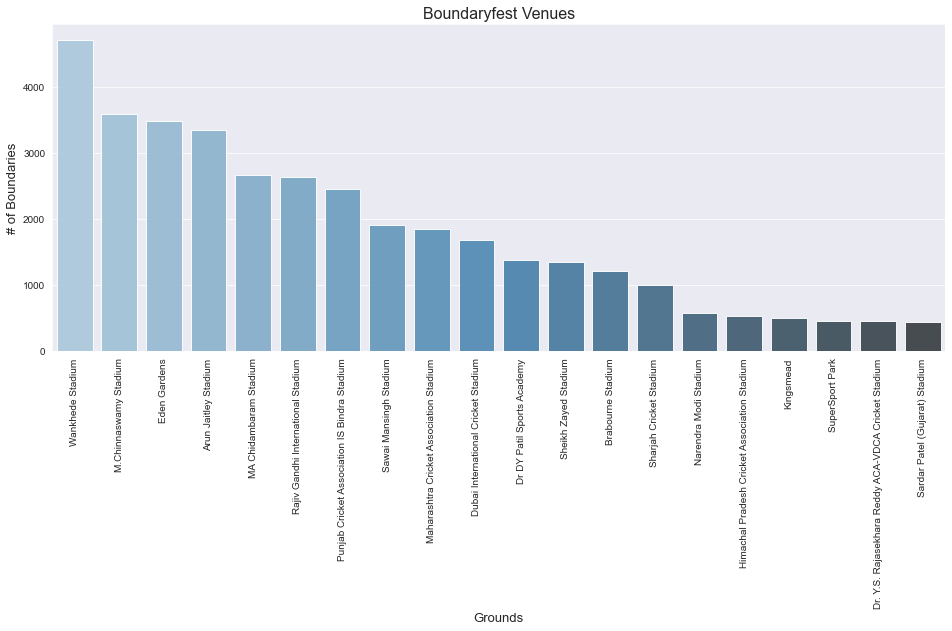

In [64]:
# Venues where most boundaries are scored 
plt.figure(figsize=(16,6))
sns.barplot(x=list(venue_boundaries_dict.keys()), y=list(venue_boundaries_dict.values()), palette="Blues_d",alpha=0.9)
plt.title("Boundaryfest Venues",fontsize=16)
plt.xlabel("Grounds",fontsize=13)
plt.ylabel("# of Boundaries",fontsize = 13)
plt.xticks(rotation=90)

plt.show()

In [65]:
df['total_runs'] = df['away_runs'] + df['home_runs']
df['total_wickets'] = df['away_wickets'] + df['home_wickets']
venue_runs = df.groupby('venue_name')['total_runs'].sum().sort_values(ascending = False)
venue_runs_dict = dict(venue_boundaries[:20])

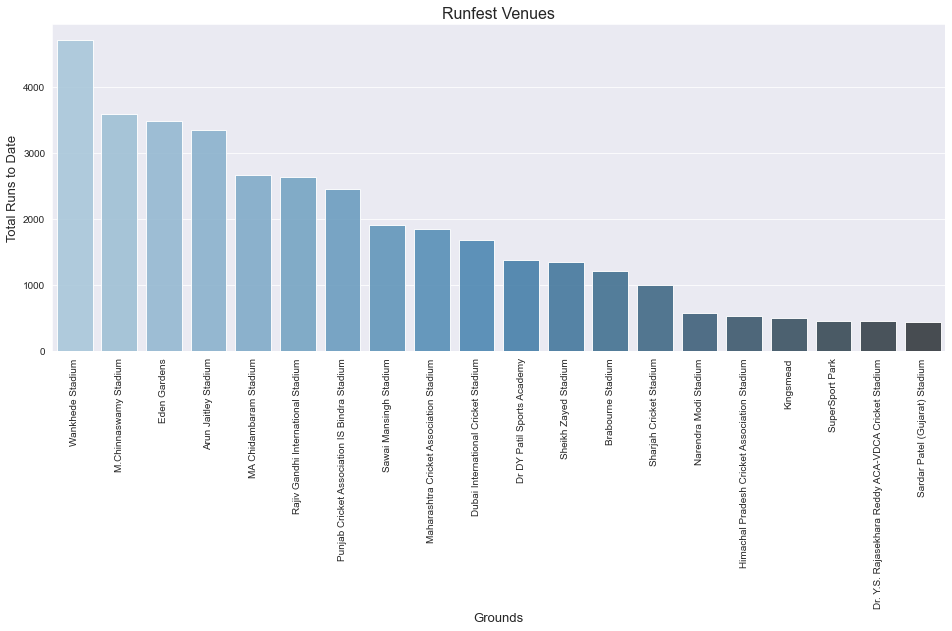

In [66]:
# Venues where the most runs are scored
plt.figure(figsize=(16,6))
sns.barplot(x=list(venue_runs_dict.keys()), y=list(venue_runs_dict.values()), palette="Blues_d",alpha=0.9)
plt.title("Runfest Venues",fontsize=16)
plt.xlabel("Grounds",fontsize=13)
plt.ylabel("Total Runs to Date",fontsize = 13)
plt.xticks(rotation=90)

plt.show()

In [67]:
df.reset_index(drop=True, inplace=True)

In [68]:
run_venues = list(venue_runs.index[:10])

bat_high_run_rows = len(df.loc[(df['venue_name'].isin(run_venues)) & (df['decision'] == 'bat')])
bat_rows = (df['decision'] != 'bat').sum()
second_inning_runs = df.loc[df['venue_name'].isin(run_venues),'2nd_inning_score'].sum()
first_inning_runs = df.loc[df['venue_name'].isin(run_venues),'1st_inning_score'].sum()

toss_high_runs = len(df.loc[df['venue_name'].isin(run_venues) & (df['winner'] == df['toss_won'])])
high_run_ground_games = df['venue_name'].isin(run_venues).sum()

In [69]:
labels = ['general','high scoring venues']
vals = [bat_rows,bat_high_run_rows]

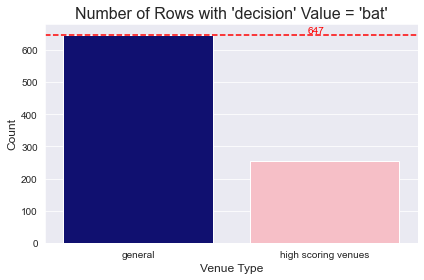

In [70]:
labels = ['general', 'high scoring venues']
vals = [bat_rows, bat_high_run_rows]

# Determine the colors for the bars
colors = ['navy', 'lightpink']
# Determine the index of the bar with the higher height
higher_bar_index = vals.index(max(vals))

# Create the bar plot
plt.figure(figsize=(6, 4))
sns.barplot(x=labels, y=vals, palette=colors)

# Add the dashed red line at the level of the higher bar
plt.axhline(y=max(vals), color='red', linestyle='--')
# Label the dashed line with the y-axis value of the higher bar
plt.text(len(labels) - 1, max(vals), str(max(vals)), ha='right', va='bottom', color='red')

# Set the title, x-label, and y-label
plt.title("Number of Rows with 'decision' Value = 'bat'", fontsize=16)
plt.xlabel("Venue Type", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()


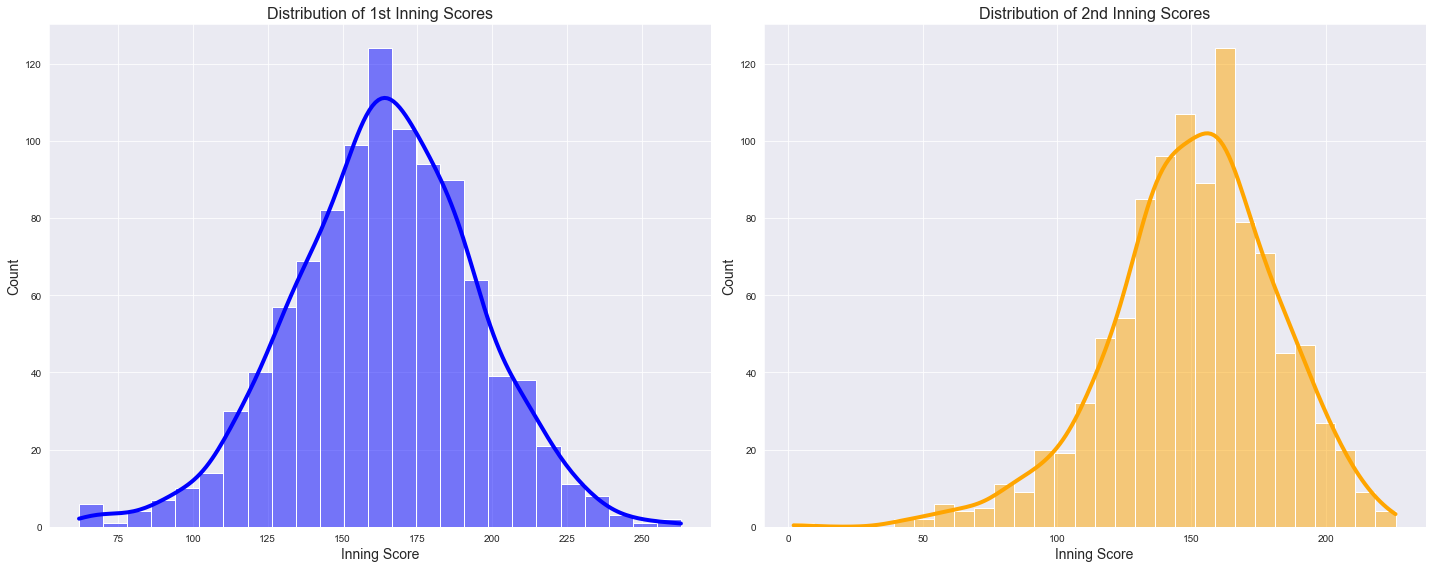

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot for 1st inning score
sns.histplot(ax=axes[0], data=df, x='1st_inning_score', color='blue', alpha=0.5, label='1st Inning Score',kde = True, line_kws={'linewidth': 4})
axes[0].set_xlabel('Inning Score',fontsize=14)
axes[0].set_ylabel('Count',fontsize=14)
axes[0].set_title('Distribution of 1st Inning Scores',fontsize=16)

# Plot for 2nd inning score
sns.histplot(ax=axes[1], data=df, x='2nd_inning_score', color='orange', alpha=0.5, label='2nd Inning Score',kde = True, line_kws={'linewidth': 4})
axes[1].set_xlabel('Inning Score',fontsize=14)
axes[1].set_ylabel('Count',fontsize=14)
axes[1].set_title('Distribution of 2nd Inning Scores',fontsize=16)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


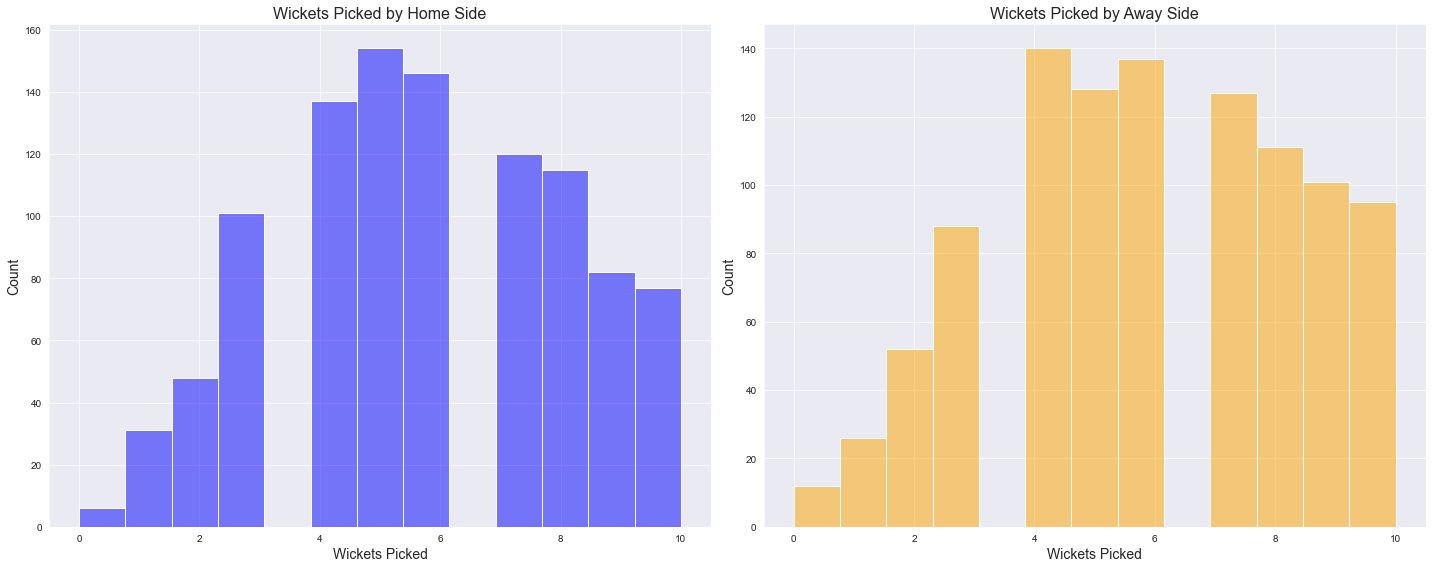

In [72]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot for 1st inning score
sns.histplot(ax=axes[0], data=df, x='home_wickets', color='blue', alpha=0.5, label='home_wickets')
axes[0].set_xlabel('Wickets Picked',fontsize=14)
axes[0].set_ylabel('Count',fontsize=14)
axes[0].set_title('Wickets Picked by Home Side',fontsize=16)

# Plot for 2nd inning score
sns.histplot(ax=axes[1], data=df, x='away_wickets', color='orange', alpha=0.5, label='away_wickets')
axes[1].set_xlabel('Wickets Picked',fontsize=14)
axes[1].set_ylabel('Count',fontsize=14)
axes[1].set_title('Wickets Picked by Away Side',fontsize=16)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

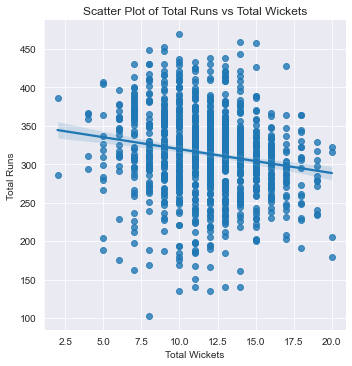

In [73]:
sns.lmplot(data=df, y='total_runs', x='total_wickets')
plt.xlabel('Total Wickets')
plt.ylabel('Total Runs')
plt.title('Scatter Plot of Total Runs vs Total Wickets')
plt.show()


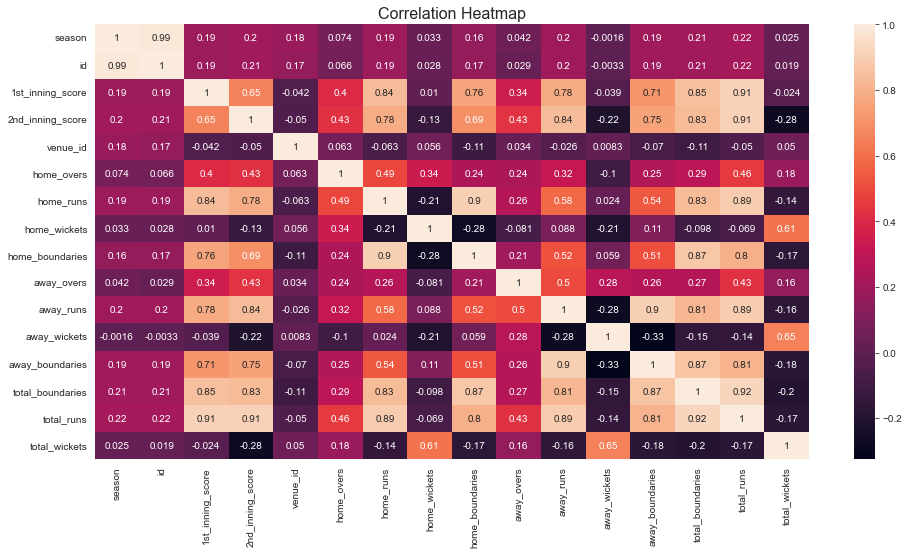

In [74]:
correlation_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(correlation_matrix, annot=True,)
plt.title('Correlation Heatmap',fontsize=16)
plt.show()

## Statistical Inference 

### Trying to discover whether a 165+ 1st innings score is an indicator for a playoff win

In [75]:
df['playoff'] = df['description'].str.contains('1st Semi-Final|2nd Semi-Final|Final')

#### Defining the NULL and the Alternate Hypothesis

* **NULL Hypothesis:** 
    * Winning after setting a target of 165+ happens only by chance (i.e., you get no statistical advantage at winning if you score 165+ in the 1st innings)

* **ALTERNATE Hypothesis:** 
    * Setting a target of 165+ indicates a greater likelihood of winning the playoff game 

#### Defining the method 

We can observe the following protocol to carry out the statistical inference based on p-value:
1. Find the population statistic i.e., what proportion of teams won the game when they scored 165+ in the 1st innings  throughout the IPL
2. Then we can find the observed statistic in our target population i.e., how many teams won the game when they scored 165+ in the 1st innings in the playoffs 
3. We can then generate 10,000 random samples of the same size as the sample in (2) to observe what the theoretical distribution of teams winning playoff matches after setting a target of 165+ should look like 
4. We can then observe how the observed statistic measures against this theoretical distribution. The p-value will be indicator on the basis of which we either reject or accept the NULL hypothesis 

#### What are we trying to model ?

**Description of Using a P-Value Test**

This explanation outlines the process of using a p-value test to assess the significance of winning a playoff game after setting a target of 165+ 1st innings runs in the IPL.

**_Identifying Relevant Teams_**

* First, we determine the number of teams that have scored 165+ runs in the IPL playoffs.
* Next, we examine the proportion of these teams that have won the playoff games.

**_Creating Alternate Universes_**

* We create 10,000 samples of the playoff games, representing alternate universes.
* These samples are obtained from a normal distribution centered around the test statistic.

**_Analyzing the Alternate Universes_**

* Within each of the 10,000 alternate universes, we calculate the number of teams that have won the playoffs after setting a target of 165+ runs.
* These counts form a histogram, which approximates a normal distribution due to the central limit theorem.

**_Plotting the Observed Value_**

* We plot the observed value on the histogram generated from the alternate universes.
* By examining where the observed value appears on the histogram, we gain insights into its significance.

**_Interpreting the P-Value_**

* If the observed value falls beyond the shaded p-value region on the histogram, we confidently conclude that winning a playoff game after setting a target of 165+ runs is not a random occurrence.
* Conversely, if the observed value falls within the non-shaded region, we infer that it could have happened randomly.

In [76]:
# lets find the total number of teams that scored 165 >= 
beyond_or_165 = len(df[df['1st_inning_score'] >= 165])
# no. of teams that won the matches after scoring >= 165 
winner_165 = len(df[(df['toss_won'] == df['winner']) & (df['decision'] == 'bat') & (df['1st_inning_score'] >= 165)])+ len(df[(df['toss_won'] != df['winner']) & (df['decision'] == 'bowl') & (df['1st_inning_score'] >= 165)])
# ratio of teams that win after scoring 165+ in 1st innings . This is our population statistic 
pop_stat = round(winner_165/beyond_or_165,5)

eligible_pop_range = [1-pop_stat,pop_stat]

In [77]:
# obtaining the observed statistic -> proportion of teams that won the playoffs given they scored 165+ in 1st innings 
sample_size = num_playoffs_165 = len(df[(df['playoff'] == True) & (df['1st_inning_score'] >= 165)])
# no. of teams that won scoring >= 165 in 1st innings 
obs_stat = winner_165_playoff = len(df[(df['toss_won'] == df['winner']) & (df['decision'] == 'bat') & (df['1st_inning_score'] >= 165) & (df['playoff']==True)])+ len(df[(df['toss_won'] != df['winner']) & (df['decision'] == 'bowl') & (df['1st_inning_score'] >= 165) & (df['playoff'] == True)])
print(num_playoffs_165)
print(obs_stat)

13
9


In [78]:
# creating a function to simulate samples under the NULL Hypothesis 

def one_sample(sample_size,pop_stat):
    return sample_size * sample_proportions(sample_size, pop_stat).item(0)

def simulate_null(reps, sample_size, pop_stats):
    sample = [one_sample(sample_size,pop_stats) for _ in range(reps+1)]
    return sample

In [79]:
null_samples = simulate_null(10000,sample_size,eligible_pop_range)

In [80]:
null_samples= np.array(null_samples)

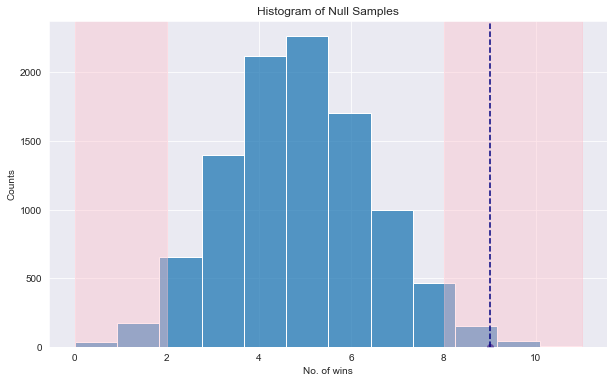

In [81]:
plt.figure(figsize= (10,6))

sns.histplot(null_samples, bins=12)
plt.xlabel('No. of wins')
plt.ylabel('Counts')
plt.title('Histogram of Null Samples')

plt.axvline(obs_stat, color='navy', linestyle='--')
plt.scatter(obs_stat, 0, color='navy', marker='o')

# Calculate the 2.5th and 97.5th percentiles
quantile_2p5 = np.percentile(null_samples, 2.5)
quantile_97p5 = np.percentile(null_samples, 97.5)

# Shade the area to the left of the 2.5th percentile
plt.axvspan(min(null_samples), quantile_2p5, color='pink', alpha=0.4)

# Shade the area to the right of the 97.5th percentile
plt.axvspan(quantile_97p5, max(null_samples), color='pink', alpha=0.4)

plt.show()